In [214]:
# %matplotlib notebook
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display,clear_output
import multiprocessing
import time
from matplotlib.patches import Rectangle
import os
import cv2

In [215]:
class Unit:
    def __init__(
        self, field, swarm, x, y, pheremone_strength, speed, power, attack_range
    ):
        #Position
        self.x = x
        self.y = y


        self.swarm = swarm #swarm_id

        self.field = field #field data

        self.health = 10

        #what we are evolving
        self.attack_range = attack_range
        self.speed = speed
        self.power = power
        self.pheremone_strength = pheremone_strength

        #Stats
        self.kill_count = 0
        self.time_alive = 0
        self.food_returned_count = 0
        self.score = 0
        self.has_food = False

        self.heading = random.randint(0, 359) # we can make this an evolving param too

    #goes to nest oncw has food
    def uphill_nest_scent(self):
        if self.swarm == 0:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest1_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest1_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest1_scent
            except:
                scent_left = 0

            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45
        else:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest2_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest2_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest2_scent
            except:
                scent_left = 0
            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45

    def search_for_food(self):
        if self.field.patch_here(self.x, self.y) != None:
            if self.field.patch_here(self.x, self.y).food > 0:
                self.has_food = True
                self.field.patch_here(self.x, self.y).food -= 1
        else:
            if self.swarm == 0:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_1
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_1
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_1
                except:
                    pheromone_left = 0
            else:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_2
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_2
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_2
                except:
                    pheromone_left = 0


            # Choose the direction with the highest pheromone concentration
            if pheromone_right > pheromone_ahead and pheromone_right > pheromone_left:
                self.heading += 45
            elif pheromone_left > pheromone_ahead and pheromone_left > pheromone_right:
                self.heading -= 45

    def return_to_nest(self):
        if self.swarm == 0:
            if self.field.patch_here(self.x, self.y).nest1:
                self.has_food = False
                self.heading += 180
                self.field.swarms[0].food_count +=1
                self.food_returned_count += 1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_1 += self.pheremone_strength

                for dx in range(-3, 4):
                    for dy in range(-3, 4):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 2)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_1 += decayed_strength

                self.uphill_nest_scent()
        else:
            if self.field.patch_here(self.x, self.y).nest2:
                self.has_food = False
                self.heading += 180
                self.field.swarms[1].food_count +=1
                self.food_returned_count +=1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_2 += self.pheremone_strength

                for dx in range(-8, 9):
                    for dy in range(-8, 9):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 3.5)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_2 += decayed_strength

                self.uphill_nest_scent()

    def move(self):

        if self.has_food:
            self.return_to_nest()
        else:
            self.search_for_food()

        self.heading += random.randint(-30, 30)
        self.forward()
        self.time_alive += 1

    def forward(self):

        new_x = self.x + math.cos(math.radians(self.heading)) * self.speed
        new_y = self.y + math.sin(math.radians(self.heading)) * self.speed
        while (
            new_x < 0
            or new_x > self.field.width
            or new_y < 0
            or new_y > self.field.height
        ):
            new_x = self.x - math.cos(math.radians(self.heading)) * self.speed
            new_y = self.y - math.sin(math.radians(self.heading)) * self.speed
            self.heading += random.randint(-40, 40)
            new_x = self.x + math.cos(math.radians(self.heading)) * self.speed
            new_y = self.y + math.cos(math.radians(self.heading)) * self.speed
        self.x = new_x
        self.y = new_y

    def attack(self):
        enemies = self.field.swarms[not self.swarm]
        for enemy in random.sample(enemies.active_units, len(enemies.active_units)):
            if enemy != self:
                distance = math.sqrt((self.x - enemy.x) ** 2 + (self.y - enemy.y) ** 2)
                if distance <= self.attack_range:
                    enemy.health -= self.power
                    if enemy.health <= 0:
                        self.kill_count += 1
                    break

    def eval(self):
        if self.swarm == 0:
           self.score = (.6 * self.food_returned_count) + (.2 * self.kill_count) + (.2 +self.time_alive)
        else:
            self.score = (.2 * self.food_returned_count) + (.2 * self.kill_count) + (.6 +self.time_alive)
        # implement logic upon unit death

In [216]:
class Swarm:
    def __init__(self, field, id, max_units, start_x, start_y, elites):
        self.id = id
        self.max_units = max_units
        self.field = field
        self.all_units =[]
        self.active_units = []
        self.dead_units = []
        self.pheromone_map = (field.width, field.height)
        self.x = start_x
        self.y = start_y
        self.elites = elites
        self.food_count=0
        #print(type(self.elites))
        self.populate_swarm()

    def processing_move(unit):
        unit.move()
    def gene_pool(self):
        pool = []
        for elite in self.elites:
            pool.append([elite.speed, elite.power, elite.attack_range, elite.pheremone_strength])
        return pool

    def populate_swarm(self):
        dummy = 0
        if not self.elites:
            for i in range(self.max_units):
                speed = random.uniform(0, 1)
                power = random.randint(1, 5)
                attack_range = random.uniform(0.5, 3)
                p_strength = random.randint(1, 3)
                ant = Unit(
                    self.field,
                    self.id,
                    self.x,
                    self.y,
                    p_strength,
                    speed,
                    power,
                    attack_range,
                )
                self.active_units.append(ant)
        else:
            for i in range(self.max_units):
                # Select a random elite from the gene pool
                elite_index = random.randint(0,4)
                #print(type(self.elites))
                #elite = self.elites[elite_index]
                pool = self.gene_pool()
                # Choose a random attribute to modify
                gene = random.randint(0, 3)

                # Modify the selected attribute with some randomness
                if gene == 0:  # Modify speed
                    speed = pool[elite_index][gene] * random.uniform(0.90, 1.10)
                    power = random.randint(1, 5)
                    attack_range = random.uniform(0.5, 3)
                    p_strength = random.randint(1, 3)
                elif gene == 1:  # Modify power
                    speed = random.uniform(0, 1)
                    power = pool[elite_index][gene] + random.randint(-1, 1)
                    attack_range = random.uniform(0.5, 3)
                    p_strength = random.randint(1, 3)
                elif gene == 2:  # Modify attack_range
                    speed = random.uniform(0, 1)
                    power = random.randint(1, 5)
                    attack_range = pool[elite_index][gene] * random.uniform(0.90, 1.10)
                    p_strength = random.randint(1, 3)
                else:  # Modify p_strength
                    speed = random.uniform(0, 1)
                    power = random.randint(1, 5)
                    attack_range = random.uniform(0.5, 3)
                    p_strength = pool[elite_index][gene] + random.randint(-1, 1)

                # Ensure the modified attributes stay within valid ranges
                speed = max(0, min(1, speed))
                power = max(1, min(5, power))
                attack_range = max(0.5, min(3, attack_range))
                p_strength = max(1, min(3, p_strength))

                # Create a new unit with modified attribute
                ant = Unit(
                    self.field,
                    self.id,
                    self.x,
                    self.y,
                    p_strength,
                    speed,
                    power,
                    attack_range,
                )
                self.active_units.append(ant)

        self.all_units = self.active_units
        # populate swarm and initialize random stats for each unit
    
    def check_death(self):
        for unit in self.active_units:
            if unit.health <= 0:
                self.active_units.remove(unit)
                self.dead_units.append(unit)

    def eval_swarm(self):
        # Evaluate each ant
        for ant in self.all_units:
            ant.eval()
        
        # Sort the array of live ants based on their scores (in descending order)
        self.all_units.sort(key=lambda ant: ant.score, reverse=True)
        
        # Select the top 5 ants as elites
        self.elites = self.all_units[:min(5, len(self.all_units))]
        
        return self.elites

    def print_stats(self):
        for elite in self.elites:
            print(f"speed- {elite.speed} power- {elite.power} p_strength- {elite.pheremone_strength} range- {elite.attack_range} time alive- {elite.time_alive} food collected-{elite.food_returned_count} kill count-{elite.kill_count} ") 


        

    
    def update(self):
        # Implement any other updates for the swarm i cant think of anything but here is extra stuff
        pass

In [217]:
class Patch:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pheremone_1 = 0
        self.pheremone_2 = 0
        self.food = 0
        self.nest1 = False
        self.nest2 = False
        self.nest1_scent = 0
        self.nest2_scent = 0
        self.food_source_number = 0
        self.rect = None

In [218]:
class Battlefield:
    def __init__(self, width, height):
        self.width = width
        self.height = height

        # ADDED
        self.total_food = 0

        # not being used
        self.resource_nodes = []
        self.swarms = []

        self.tick_count = 0
        self.evolution = 0

        self.swarms.append(Swarm(self, 0, 50, 0, self.height / 2, []))
        self.swarms.append(Swarm(self, 1, 50, self.width, self.height / 2, []))

        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, width)
        self.ax.set_ylim(0, height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

        self.patches = [[Patch(x, y) for y in range(height)] for x in range(width)] #making 1x1 blocks over the map
        self.populate_resources()
    
    # ADDED
    def reset(self, elites0, elites1):
        
        self.swarms = []
        self.tick_count = 0
        self.total_food = 0

        # update swarms
        # pass elites to function to amplify swarm stats
        self.swarms.append(Swarm(self, 0, 50, 0, self.height / 2, elites0))
        self.swarms.append(Swarm(self, 1, 50, self.width, self.height / 2, elites1)   )     

        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, self.width)
        self.ax.set_ylim(0, self.height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

        self.patches = [[Patch(x, y) for y in range(self.height)] for x in range(self.width)] #making 1x1 blocks over the map
        self.populate_resources()
        

    def setup_nest(self, patch: Patch):
        if math.sqrt((patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2) < 2:
            patch.nest1 = True
        patch.nest1_scent = 200 - math.sqrt(
            (patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2
        )
        if (
            math.sqrt((patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2)
            < 2
        ):
            patch.nest2 = True
        patch.nest2_scent = 200 - math.sqrt(
            (patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2
        )

    def setup_food(self, patch):
        if (
            math.sqrt(
                (patch.x - 0.6 * self.width) ** 2 + (patch.y - 0.2 * self.height) ** 2
            )
            < 5
        ):
            patch.food_source_number = 1
        # elif (
        #     math.sqrt(
        #         (patch.x - 0.6 * self.width) ** 2 + (patch.y - 0.6 * self.height) ** 2
        #     )
        #     < 5
        # ):
        #     patch.food_source_number = 2
        # elif (
        #     math.sqrt(
        #         (patch.x - 0.8 * self.width) ** 2 + (patch.y - 0.8 * self.height) ** 2
        #     )
        #     < 5
        # ):
        #     patch.food_source_number = 3
        if patch.food_source_number > 0:
            patch.food = random.choice([1, 2])

    def patch_here(self, x, y):
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.patches[int(x)][int(y)]
        return None

    def patch_ahead(self, x, y, heading):
        dx = math.cos(math.radians(heading))
        dy = math.sin(math.radians(heading))
        return self.patch_here(x + dx, y + dy)

    def patch_right_and_ahead(self, x, y, heading, angle):
        dx = math.cos(math.radians(heading + angle))
        dy = math.sin(math.radians(heading + angle))
        return self.patch_here(x + dx, y + dy)

    def populate_resources(self):
        for x in range(self.width):
            for y in range(self.height):
                self.setup_nest(self.patches[x][y])
                self.setup_food(self.patches[x][y])

                # ADDED
                self.total_food += 1
        # populate the resources across the search space
        colors = ["yellow", "green", "orange"]
        for x in range(self.width):
            for y in range(self.height):
                if self.patches[x][y].nest1:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="red"
                    )
                    self.ax.add_patch(rect)
                elif self.patches[x][y].nest2:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="blue"
                    )
                    self.ax.add_patch(rect)
                elif (
                    self.patches[x][y].food_source_number > 0
                    and self.patches[x][y].food > 0
                ):
                    rect = Rectangle(
                        (x, y),
                        1,
                        1,
                        linewidth=1,
                        facecolor=colors[self.patches[x][y].food_source_number - 1],
                    )
                    self.ax.add_patch(rect)

    def tick(self):
        for x in range(self.width):
            for y in range(self.height):
                self.patches[x][y].pheremone_1 = math.floor(
                    self.patches[x][y].pheremone_1 * 0.7
                )
                self.patches[x][y].pheremone_2 = math.floor(
                    self.patches[x][y].pheremone_2 * 0.7
                )
        for ant in self.swarms[0].active_units:
            ant.move()
        for ant in self.swarms[1].active_units:
            ant.move()
        for ant in self.swarms[0].active_units + self.swarms[1].active_units:
            ant.attack()
        for swarm in self.swarms:
            swarm.check_death()
        # print(f"\rSwarm 1: {self.swarms[0].food_count} Swarm 2: {self.swarms[1].food_count}", end="")
        self.tick_count += 1

    def visualize(self):
        colors = ["yellow", "green", "orange"]
        refresh = False
        for x in range(self.width):
            for y in range(self.height):
                if (
                    self.patches[x][y].food_source_number > 0
                    and self.patches[x][y].food == 0
                ):
                    for patch in self.ax.patches:
                        patch.remove()
                    refresh = True
                    break
        if refresh:
            for x in range(self.width):
                for y in range(self.height):
                    if self.patches[x][y].nest1:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="red",
                        )
                        self.ax.add_patch(rect)
                    elif self.patches[x][y].nest2:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="blue",
                        )
                        self.ax.add_patch(rect)
                    elif (
                        self.patches[x][y].food_source_number > 0
                        and self.patches[x][y].food > 0
                    ):
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            facecolor=colors[self.patches[x][y].food_source_number - 1],
                        )
                        self.ax.add_patch(rect)

                    # visualizing nest pheromones
                    # elif (
                    #     self.patches[x][y].nest1_scent >0 can change to pheromone 1 or 2
                    # ):
                    #     rect = Rectangle(
                    #         (x, y),
                    #         1,
                    #         1,
                    #         linewidth=1,
                    #         facecolor=(1,0,0,np.interp(self.patches[x][y].nest1_scent, [0, 200], [0, .8])),
                    #     )
                    #     self.ax.add_patch(rect)
                    # elif (
                    #     self.patches[x][y].nest2_scent >0
                    # ):
                    #     rect = Rectangle(
                    #         (x, y),
                    #         1,
                    #         1,
                    #         linewidth=1,
                    #         facecolor=(0,1,0,np.interp(self.patches[x][y].nest2_scent, [0, 200], [0, .8])),
                    #     )
                    #     self.ax.add_patch(rect)

        class1_coords = [[ant.x, ant.y] for ant in self.swarms[0].active_units]
        class2_coords = [[ant.x, ant.y] for ant in self.swarms[1].active_units]
        if len(class1_coords) > 0:
            self.sc1.set_offsets(class1_coords)
        else:
            self.sc1.set_visible(False)
        if len(class2_coords) > 0:
            self.sc2.set_offsets(class2_coords)
        else:
            self.sc2.set_visible(False)

        # display(self.fig)
        # clear_output(wait=True)
        plt.savefig(os.path.join(os.getcwd(),"frames", f"frame_{self.tick_count:03d}.png"))

    def create_video(self,frames_directory, output_video_path, fps=7):
        """
        Create a video from frames saved in a directory.

        Parameters:
            frames_directory (str): Path to the directory containing frames.
            output_video_path (str): Path to save the output video.
            fps (int, optional): Frames per second for the output video. Default is 24.
        """

        # Get the list of frame files
        frame_files = sorted(os.listdir(os.path.join(os.getcwd(),frames_directory)))

        # Read the first frame to get frame size
        first_frame = cv2.imread(os.path.join(os.path.join(os.getcwd(),frames_directory, frame_files[0])))
        height, width, _ = first_frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        # Write frames to video
        for frame_file in frame_files:
            frame = cv2.imread(os.path.join(frames_directory, frame_file))
            out.write(frame)

        # Release VideoWriter and cleanup
        out.release()

In [219]:
def main():

    bf = Battlefield(50, 50)

    for round in range(1, 3):
        elites0 = []
        elites1 = []
        for i in  range(500):
            bf.tick()
            bf.visualize()

            red_ct = len(bf.swarms[0].active_units)
            blue_ct = len(bf.swarms[1].active_units)

            if(bf.total_food == 0 or (red_ct * blue_ct) == 0):
                break

            print(f"\rTick: {i}", end="")

        print("\nRound Complete\n")
        elites0=bf.swarms[0].eval_swarm()
        elites1=bf.swarms[1].eval_swarm()
        #print(type(elites0))
        #print(type(elites1))
        print("Team 1 Best")
        bf.swarms[0].print_stats()
        print("Team 2 Best")
        bf.swarms[1].print_stats()
        # deciding the winner
        if red_ct == 0:
            decision = 'blue'
        elif blue_ct == 0 or bf.swarms[0].food_count > bf.swarms[1].food_count:
            decision = 'red'
        elif red_ct > blue_ct:
            decision = 'red'
        elif red_ct < blue_ct:
            decision = 'blue'
        else:
            decision = 'draw'

        # printing results of the round
        if (decision != 'draw'):
            print(f'Team {decision} wins the round!\n')
        else:
            print("It's a draw!\n")
        txt = "out" + str(round) + ".avi"
        bf.create_video("frames", txt)
        bf.reset(elites0,elites1)
        

        

Tick: 499
Round Complete

Team 1 Best
speed- 0.5113481608857293 power- 2 p_strength- 2 range- 2.7443628745728526 time alive- 500 food collected-0 kill count-6 
speed- 0.4322929022043104 power- 3 p_strength- 3 range- 1.7495890068381463 time alive- 500 food collected-2 kill count-0 
speed- 0.31744451759086223 power- 5 p_strength- 1 range- 0.6938067817144098 time alive- 500 food collected-1 kill count-0 
speed- 0.18347838703665276 power- 5 p_strength- 2 range- 2.1382860920372044 time alive- 500 food collected-0 kill count-1 
speed- 0.19479906539169634 power- 2 p_strength- 2 range- 1.2602637546214563 time alive- 500 food collected-0 kill count-0 
Team 2 Best
speed- 0.6740873853203952 power- 4 p_strength- 3 range- 2.297872417279879 time alive- 500 food collected-2 kill count-1 
speed- 0.22876349170716692 power- 5 p_strength- 3 range- 2.8385006795001697 time alive- 500 food collected-0 kill count-2 
speed- 0.7230534884850307 power- 4 p_strength- 2 range- 0.6655268050425598 time alive- 500 fo

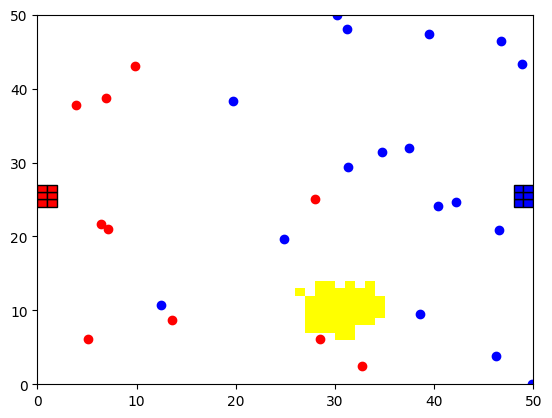

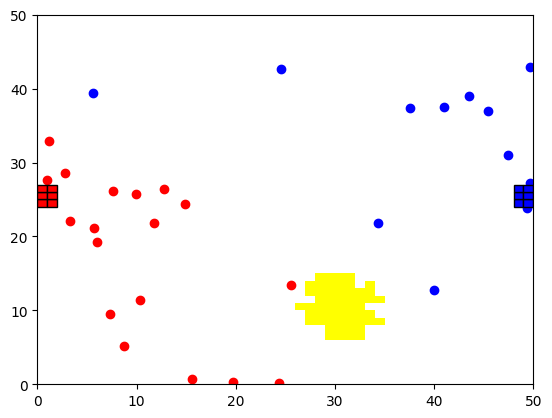

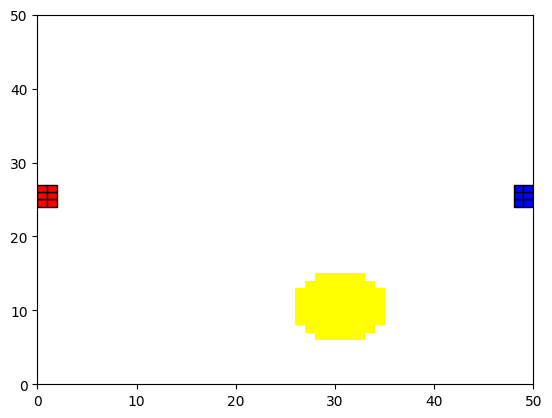

In [220]:
if __name__ == "__main__":
    main()